In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

train_gen = train_datagen.flow_from_directory(
  'drive/MyDrive/Colab Notebooks/data/MICC-F220/training',
  target_size=(64, 64), # (height, width)
  batch_size=50,
  seed=2021,
  class_mode='binary',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'drive/MyDrive/Colab Notebooks/data/MICC-F220/test',
  target_size=(64, 64), # (height, width)
  batch_size=50,
  seed=2021,
  class_mode='binary',
  shuffle=False
)

Found 176 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [5]:
from pprint import pprint
pprint(train_gen.class_indices)

{'0': 0, '1': 1}


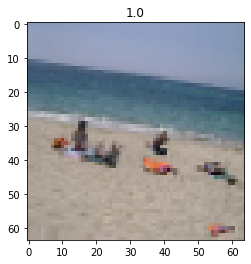

In [6]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

In [8]:
input = Input(shape=(64, 64, 3))

hidden = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(input)
hidden = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(input)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

hidden = Flatten()(hidden)
hidden = Dense(4096, activation='relu')(hidden)
hidden = Dropout(rate=0.5)(hidden)

hidden = Dense(4096, activation='relu')(hidden)
hidden = Dropout(rate=0.5)(hidden)

output = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs=input, outputs=output)

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       295168

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=100,
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/100
4/4 [==============================] - 75s 10s/step - loss: 1.5304 - acc: 0.5481 - val_loss: 0.9010 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to model.h5
Epoch 2/100
4/4 [==============================] - 2s 444ms/step - loss: 0.7654 - acc: 0.5085 - val_loss: 0.6927 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/100
4/4 [==============================] - 2s 499ms/step - loss: 0.6939 - acc: 0.4681 - val_loss: 0.6933 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/100
4/4 [==============================] - 2s 434ms/step - loss: 0.6981 - acc: 0.4777 - val_loss: 0.6937 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.50000
Epoch 5/100
4/4 [==============================] - 2s 435ms/step - loss: 0.6952 - acc: 0.4766 - val_loss: 0.6939 - val_acc: 0.5000

Epoch 00005: val_acc did not improve from 0.50000
Epoch 6/100
4/4 [==============================] - 2s 437ms/step

In [10]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')
print('Model loaded!') 

Model loaded!


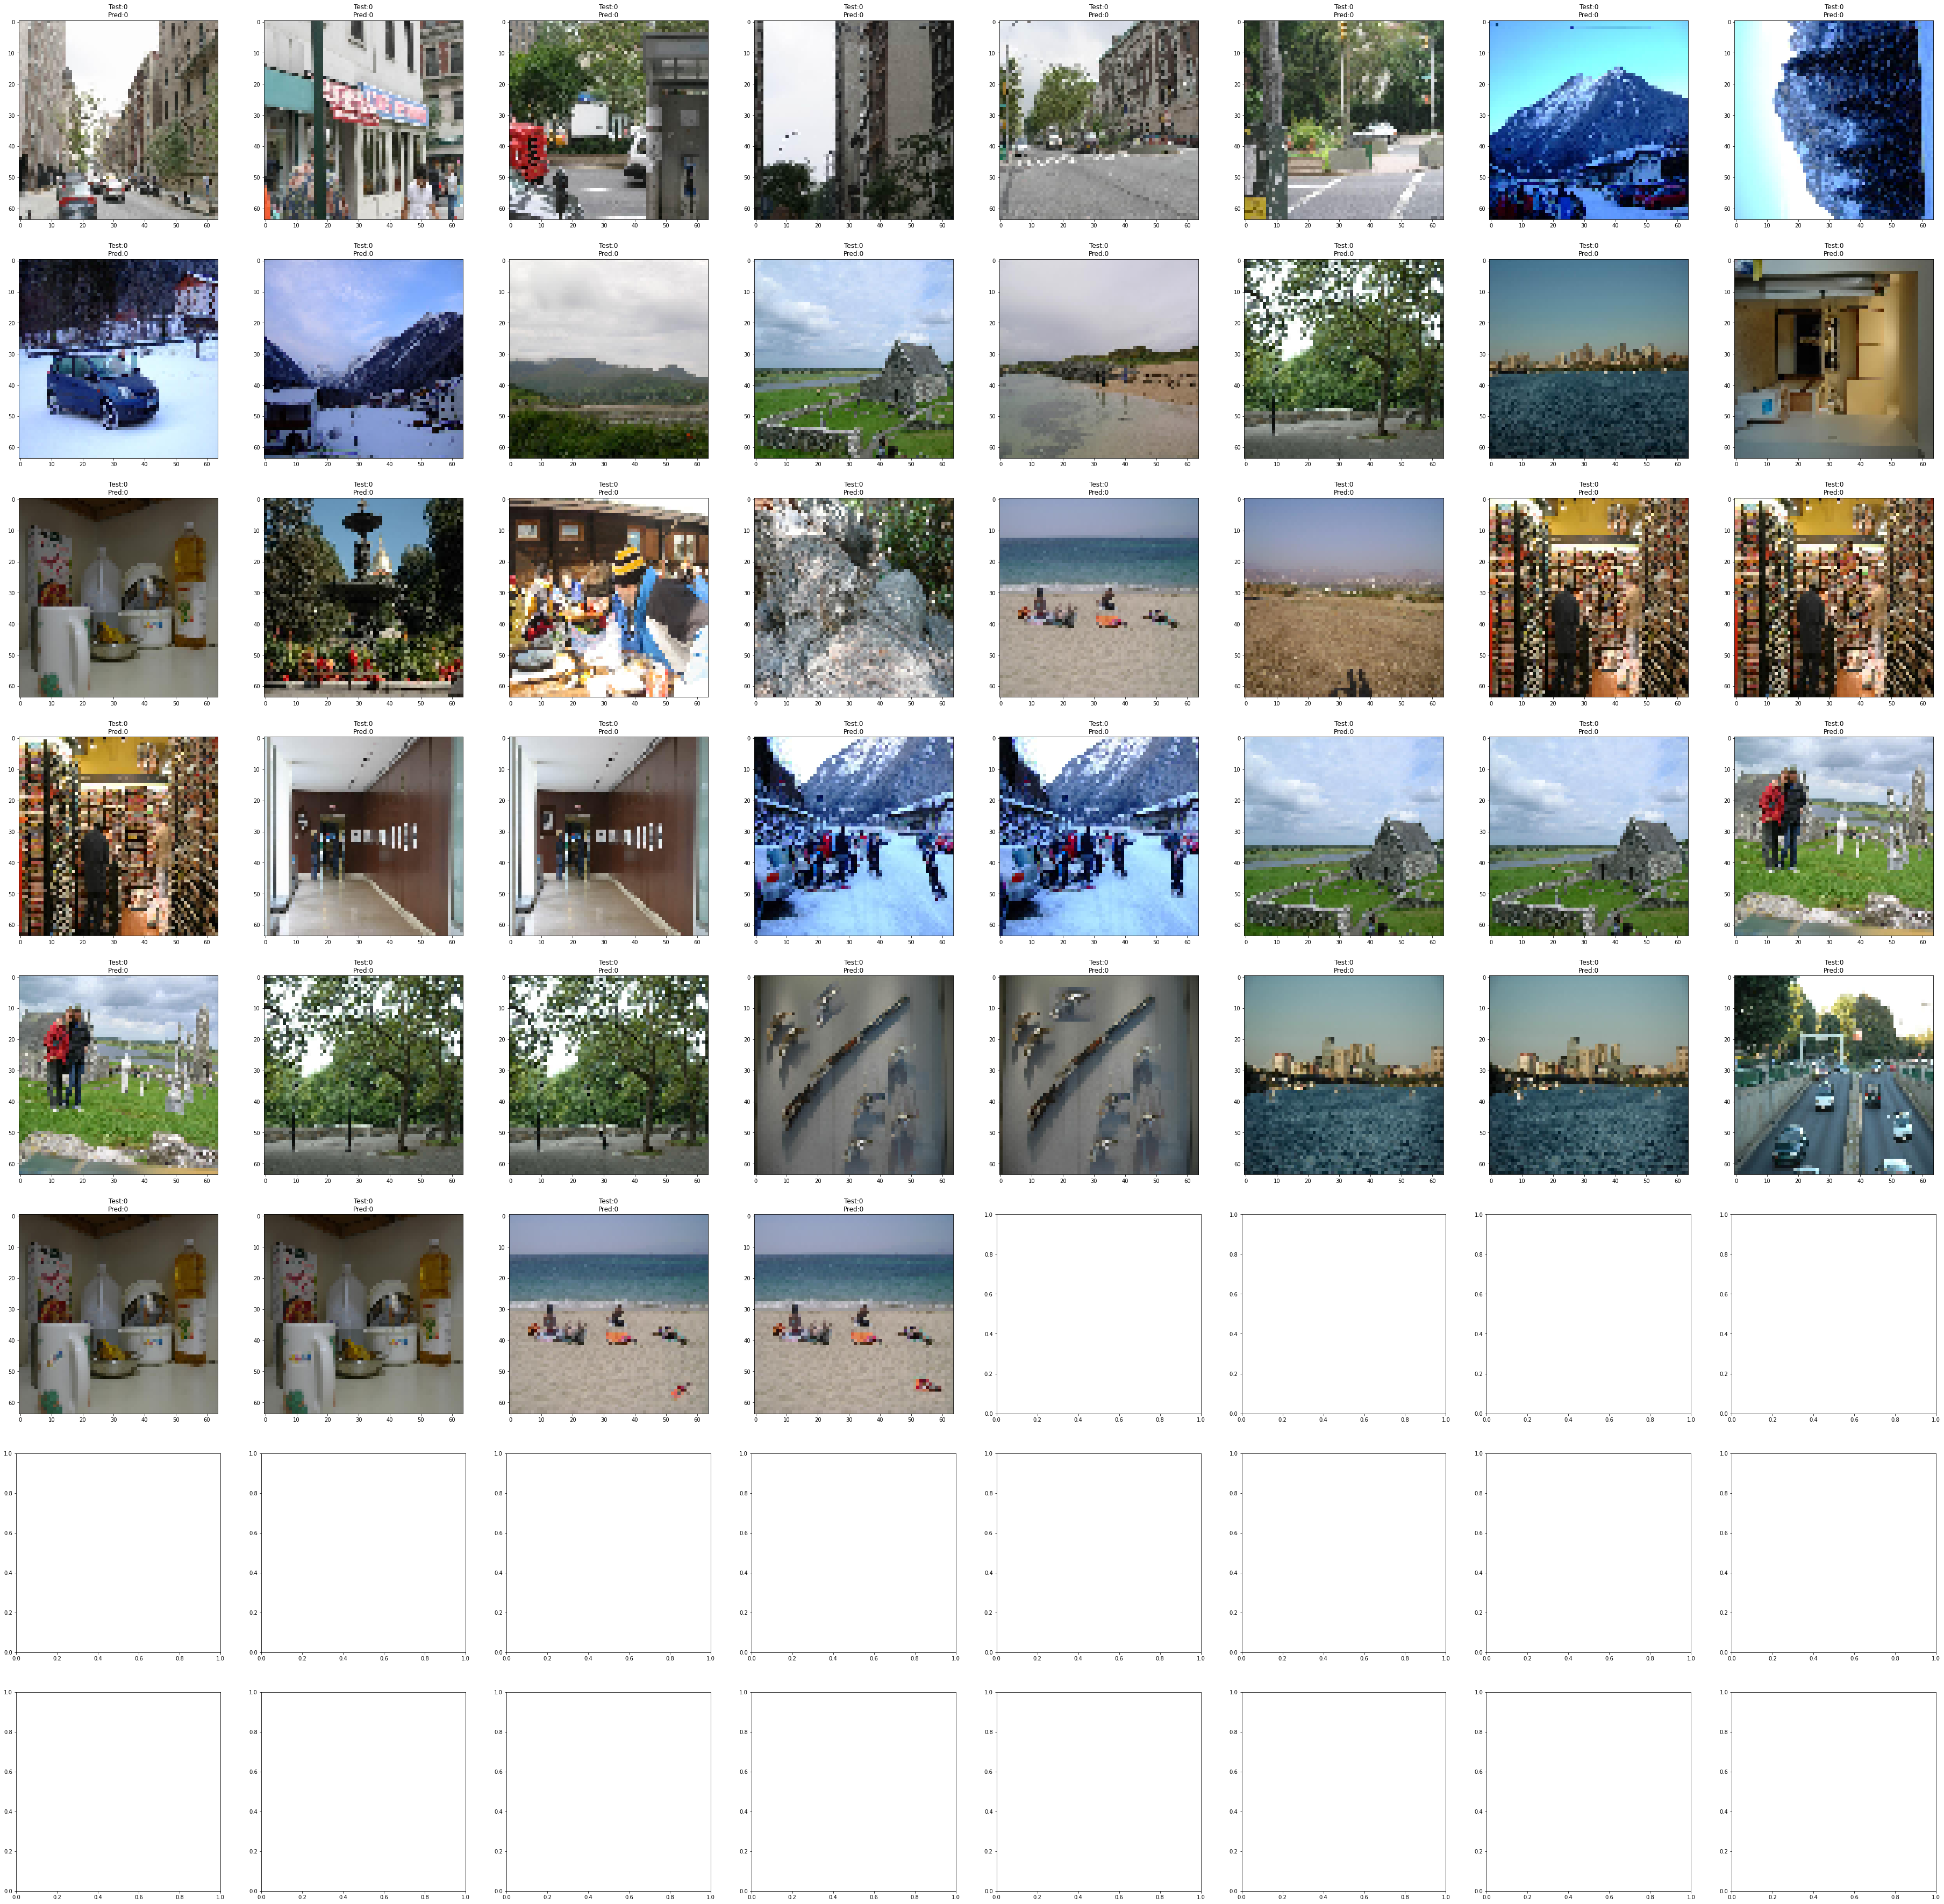

In [11]:
test_imgs, test_labels = test_gen.__getitem__(0)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(8, 8, figsize=(64, 64))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title(f"Test:{test_label}\nPred:{pred_label}")
  ax.imshow(img)

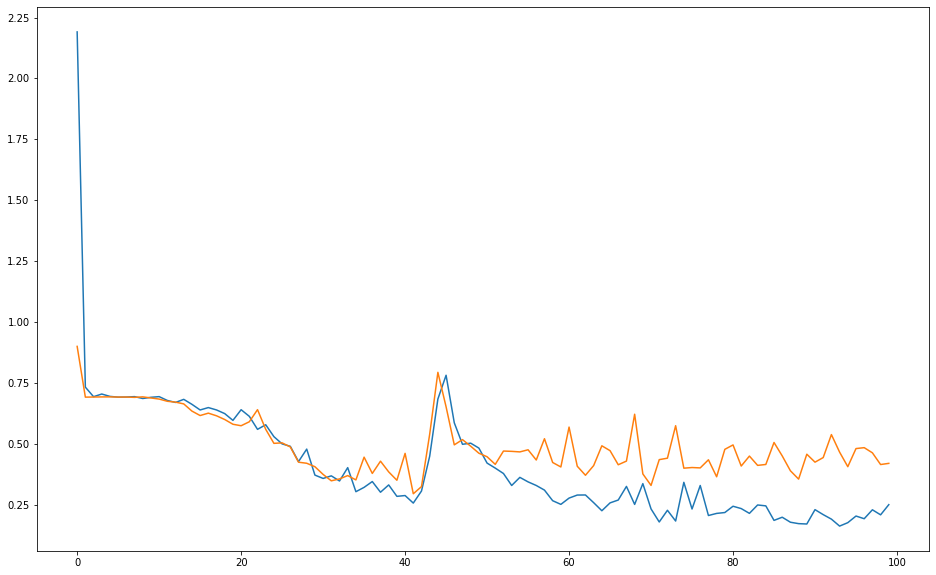

In [12]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

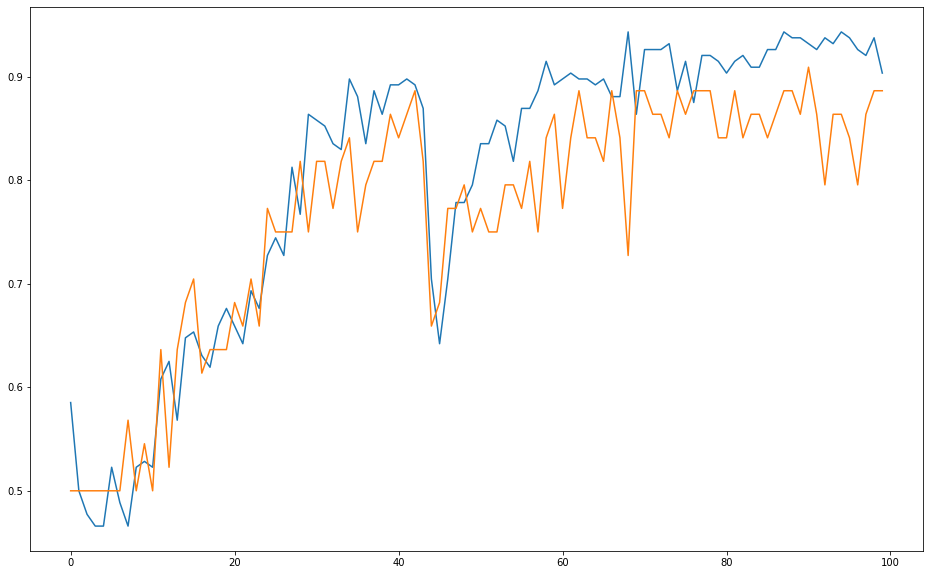

In [13]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])